# Signate開始時のお約束

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=8a43f1587bcdb05bfd7ddb4dadebc5a349a05cd6bdbb6932e2ab903702f3b065
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [4]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [5]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [6]:
!pip install kanjize

In [7]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.7 MB/s eta 0:00:00


In [110]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 28.1 MB/s eta 0:00:00


In [69]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

# データ処理開始

<ipython-input-70-8331b9fb236d>:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

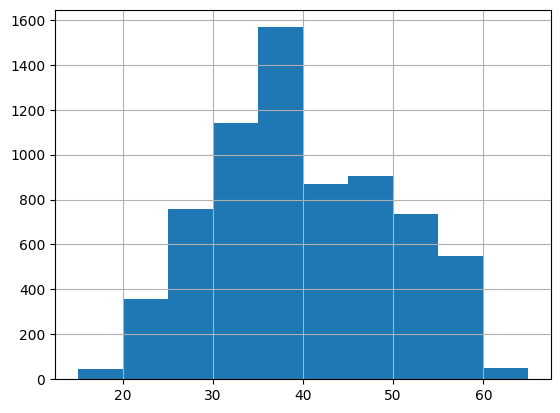

In [70]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10歳で分けて5足す
    tmp = tmp//10 * 10
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

# ヒストグラムを描く
all_df["Age"].hist()

In [71]:
#######################
# "Age"のカテゴリ分け #
#######################
# 5年毎に分ける
all_df["Age"] = (all_df["Age"].values // 5).astype(int)

# 分布の確認
all_df["Age"].value_counts()

,count
Age,
7,1567
6,1142
9,905
8,871
5,756
10,737
11,551
4,356
3,45


In [72]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損は最頻値で補完する
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")
all_df["TypeofContact"] = all_df["TypeofContact"].astype("object")
print(all_df["TypeofContact"].value_counts())

TypeofContact
Self Enquiry       4462
Company Invited    2516
Name: count, dtype: int64


In [73]:
#########################
# "CityTier"の処理 #
#########################
print(all_df["CityTier"].value_counts())

CityTier
2    3160
1    2991
3     827
Name: count, dtype: int64


In [74]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

# 5分刻みのカテゴリにする
all_df["DurationOfPitch"] = (all_df["DurationOfPitch"].values // 5).astype(int)
print(all_df["DurationOfPitch"].value_counts())

DurationOfPitch
2    2233
1    1981
3    1591
4     405
6     388
5     304
7      73
0       3
Name: count, dtype: int64


In [75]:
####################
# "Occupation"の処理 #
####################
all_df["Occupation"] = all_df["Occupation"].astype("object")
print(all_df["Occupation"].value_counts())

Occupation
Small Business    3456
Salaried          2801
Large Business     721
Name: count, dtype: int64


In [76]:
##################
# "Genger"の処理 #
##################
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])
  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"
  else:
    all_df.loc[i,"Gender"] = "Female"

# カテゴリ型にキャスト
all_df["Gender"] = all_df["Gender"].astype("object")
print(all_df["Gender"].value_counts())

Gender
Female    5946
Male      1032
Name: count, dtype: int64


In [77]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
all_df["NumberOfPersonVisiting"] = all_df["NumberOfPersonVisiting"].astype(int)
print(all_df["NumberOfPersonVisiting"].value_counts())

NumberOfPersonVisiting
2    3163
3    2773
1     686
4     356
Name: count, dtype: int64


In [78]:
##################################
# "NumberOfFollowups"の処理 #
##################################

# 欠損を-1で埋めてから中央値を取る
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# int型に変換
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].astype(int)

# 分布の確認
print(all_df["NumberOfFollowups"].value_counts())

NumberOfFollowups
4    2834
3    2561
5    1122
2     213
1     178
6      70
Name: count, dtype: int64


In [79]:
##########################
# "ProductPitched"の処理 #
##########################
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

all_df["ProductPitched"] = all_df["ProductPitched"].astype("object")

# 分布の確認
print(all_df["ProductPitched"].value_counts())

ProductPitched
Basic          2347
Deluxe         2091
Standard       1614
SuperDeluxe     640
King            286
Name: count, dtype: int64


In [80]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"].astype(int)
all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
3,4328
4,2254
5,396


In [81]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

# 分布を確認する
print(all_df["NumberOfTrips"].value_counts())

NumberOfTrips
2    2250
3    1770
5     977
1     834
7     513
4     327
6     281
8      26
Name: count, dtype: int64


In [82]:
#########################
# "Passport"の処理 #
#########################
print(all_df["Passport"].value_counts())

Passport
0    6288
1     690
Name: count, dtype: int64


In [83]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
print(all_df["PitchSatisfactionScore"].value_counts())

PitchSatisfactionScore
2    2500
4    1452
1    1439
3    1344
5     243
Name: count, dtype: int64


In [84]:
#########################
# "Designation"の処理 #
#########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

all_df["Designation"] = all_df["Designation"].astype("object")

# 分布の確認
print(all_df["Designation"].value_counts())

Designation
Executive         2330
Manager           2117
Senior Manager    1632
AVP                635
VP                 264
Name: count, dtype: int64


<Axes: >

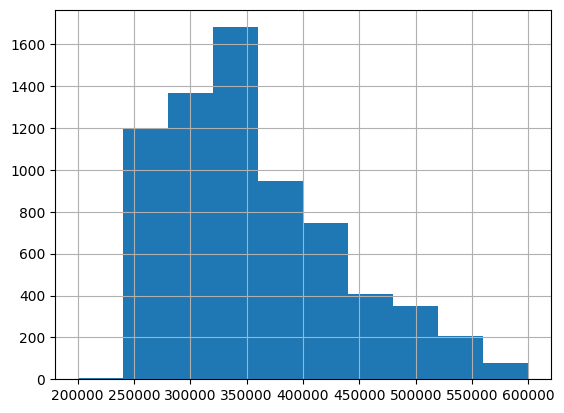

In [85]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

# 分布の確認
all_df["MonthlyIncome"].hist()

In [86]:
# 100000で割る
all_df["MonthlyIncome"] = all_df["MonthlyIncome"] / 10000
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(int)

# 5ごとに区分けする
all_df["MonthlyIncome"] = (all_df["MonthlyIncome"].values // 5).astype(int)

# 分布の確認
print(all_df["MonthlyIncome"].value_counts())

MonthlyIncome
6     2484
7     1345
5     1313
8      863
9      429
10     380
11     105
4       49
12      10
Name: count, dtype: int64


In [87]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [88]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [89]:
# 車保有率
all_df["CarHolder"] = all_df["CarHolder"].astype("int")
print(all_df["CarHolder"].value_counts())

CarHolder
0    4408
1    2570
Name: count, dtype: int64


In [90]:
# 子供の数
all_df["NumofChild"] = all_df["NumofChild"].astype("int")
print(all_df["NumofChild"].value_counts())

NumofChild
0    5015
1    1347
2     571
3      45
Name: count, dtype: int64


In [91]:
# 婚姻歴
all_df["Married"] = all_df["Married"].astype("object")
print(all_df["Married"].value_counts())

Married
Married    2846
Single     2444
Divorce    1688
Name: count, dtype: int64


In [95]:
all_df.columns

Index(['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'CarHolder', 'NumofChild', 'Married'],
      dtype='object')

In [94]:
print(all_df.dtypes)

id                          int64
Age                         int64
TypeofContact              object
CityTier                    int64
DurationOfPitch             int64
Occupation                 object
Gender                     object
NumberOfPersonVisiting      int64
NumberOfFollowups           int64
ProductPitched             object
PreferredPropertyStar       int64
NumberOfTrips               int64
Passport                    int64
PitchSatisfactionScore      int64
Designation                object
MonthlyIncome               int64
ProdTaken                 float64
CarHolder                   int64
NumofChild                  int64
Married                    object
dtype: object


In [96]:
# 順番を整列させる
col = ['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'CarHolder', 'NumofChild', 'Married']

all_df = all_df.reindex(columns=col)

In [105]:
CATS = []
for c in col:
  if all_df[c].dtype == "object":
    CATS.append(c)
print(CATS)

['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'Designation', 'Married']


In [106]:
all_df_forcorr = all_df.drop(CATS, axis=1)

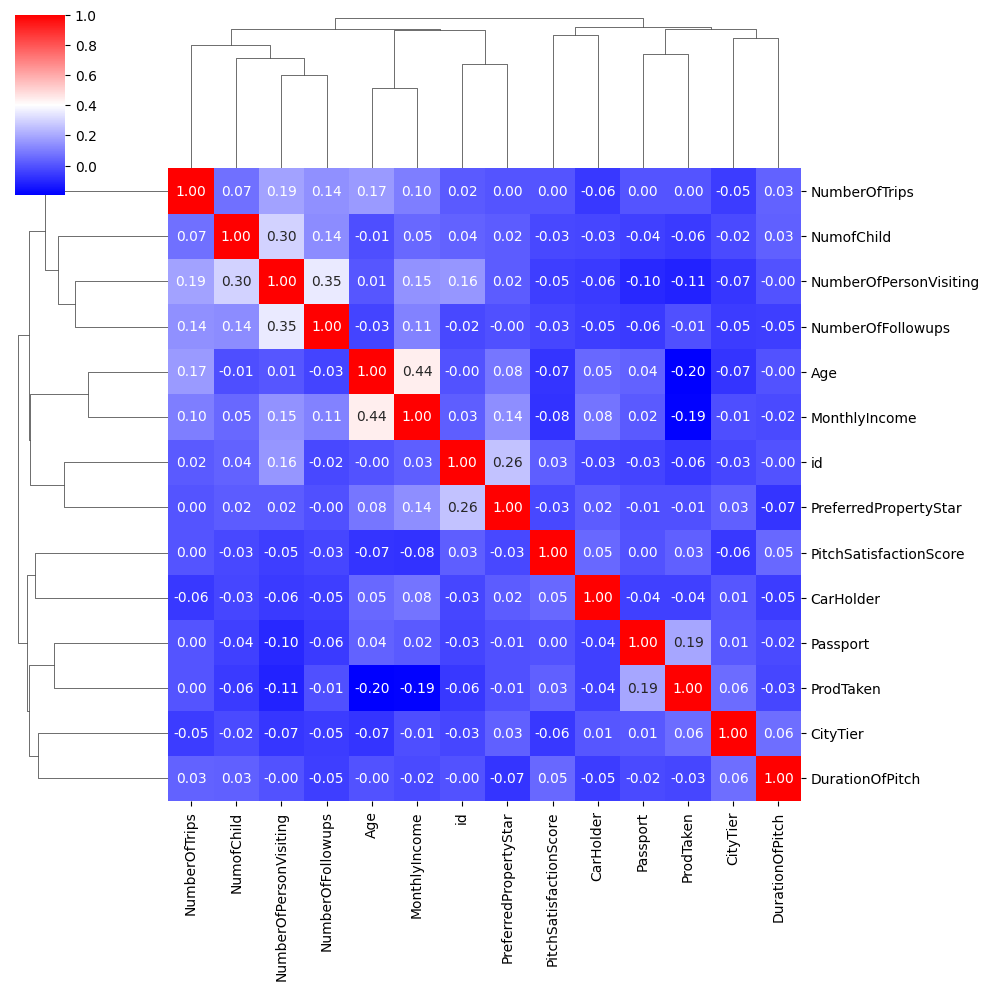

In [107]:
# 相関係数を確認する
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df_forcorr.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

# 特徴量エンジニアリング

# 学習準備

In [108]:
all_df.columns

Index(['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'CarHolder', 'NumofChild', 'Married'],
      dtype='object')

# ここから学習作業

In [126]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [127]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)
print(CATS)

['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'Designation', 'Married']


In [128]:
# カラムを制限
all_df2 = all_df[FEATURES]

# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

# 学習データ
train_x = train.drop(TARGET,axis=1)
train_y = train[TARGET]
test = test.drop(TARGET,axis=1)

# 対象の列のみ取り込み
FEATURES = test.columns

In [129]:
import pandas as pd
import numpy as np
import optuna
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.model_selection import train_test_split, StratifiedKFold
import sklearn.metrics

In [130]:
# オブジェクト型を抽出する
categorical_features = train_x.select_dtypes(include=['object']).columns.tolist()

In [131]:
categorical_features

['TypeofContact',
 'Occupation',
 'Gender',
 'ProductPitched',
 'Designation',
 'Married']

In [159]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

def objective(trial):

  params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),
        'depth' : trial.suggest_int('depth', 4, 10),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50),
        'eval_metric' :'AUC',
    }

  # KFold
  skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=32)
  auc_score = []
  pred_score = []
  pred_test_df = test_df.drop(["id"], axis=1)

  for fold, (train_idx, val_idx) in enumerate(skf.split(train, train_y), start=0):
      X_train = train_x.iloc[train_idx, :]
      y_train = train_y[train_idx]
      X_val = train_x.iloc[val_idx, :]
      y_val = train_y[val_idx]

      cb_model = CatBoostClassifier(**params)

      cb_model.fit(
            X_train, y_train,
            cat_features=categorical_features,
            eval_set=(X_val, y_val),
            use_best_model=True,
            verbose=False,
          )

      # AUC算出
      auc_score.append(cb_model.get_best_score()["validation"]["AUC"])
      # # testデータのスコア算出
      # pred_score.append(cb_model.predict_proba(pred_test_df)[:,1])

  return sum(auc_score)/len(auc_score)

In [160]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2025-05-30 22:49:09,774] A new study created in memory with name: no-name-3df92ff6-f6ed-47b7-83f0-efa79ae2e62b
<ipython-input-159-15586efe76b8>:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-159-15586efe76b8>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
[I 2025-05-30 22:49:12,304] Trial 0 finished with value: 0.8253318252662024 and parameters: {'iterations': 284, 'depth': 6, 'learning_rate': 0.1210430154016009, 'random_strength': 93, 'bagging_temperature': 0.577702536558861, 'od_type': 'It

In [161]:
print(study.best_trial)
print(study.best_params)

FrozenTrial(number=32, state=1, values=[0.8375505500775892], datetime_start=datetime.datetime(2025, 5, 30, 22, 50, 12, 464207), datetime_complete=datetime.datetime(2025, 5, 30, 22, 50, 18, 262625), params={'iterations': 221, 'depth': 6, 'learning_rate': 0.13889947564016722, 'random_strength': 87, 'bagging_temperature': 1.3629421884685191, 'od_type': 'IncToDec', 'od_wait': 27}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=300, log=False, low=50, step=1), 'depth': IntDistribution(high=10, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.01, step=None), 'random_strength': IntDistribution(high=100, log=False, low=0, step=1), 'bagging_temperature': FloatDistribution(high=100.0, log=True, low=0.01, step=None), 'od_type': CategoricalDistribution(choices=('IncToDec', 'Iter')), 'od_wait': IntDistribution(high=50, log=False, low=10, step=1)}, trial_id=32, value=None)
{'iterations': 221, 'depth': 6

In [162]:
for i, trial in enumerate(study.best_trials):
  print(trial.params)
  print([j for j in trial.values])

{'iterations': 221, 'depth': 6, 'learning_rate': 0.13889947564016722, 'random_strength': 87, 'bagging_temperature': 1.3629421884685191, 'od_type': 'IncToDec', 'od_wait': 27}
[0.8375505500775892]


In [163]:
best_params = study.best_params

In [164]:
best_params['eval_metric'] = 'AUC'

In [171]:
best_params

{'iterations': 221,
 'depth': 6,
 'learning_rate': 0.13889947564016722,
 'random_strength': 87,
 'bagging_temperature': 1.3629421884685191,
 'od_type': 'IncToDec',
 'od_wait': 27,
 'eval_metric': 'AUC'}

In [172]:
train_pred_df = pd.DataFrame()
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=32)
auc_score = []
pred_score = []
pred_test_df = test
models = []

for fold, (train_idx, val_idx) in enumerate(cv.split(train_x, train_y), start=0):
    X_train = train_x.iloc[train_idx, :]
    y_train = train_y[train_idx]
    X_val = train_x.iloc[val_idx, :]
    y_val = train_y[val_idx]

    cb_model = CatBoostClassifier(**best_params)

    cb_model.fit(
         X_train, y_train,
         cat_features=categorical_features,
         eval_set=(X_val, y_val),
         use_best_model=True,
         verbose=True,
        )

    # モデル記録
    models.append(cb_model)

    # AUC算出
    auc_score.append(cb_model.get_best_score()["validation"]["AUC"])
    # testデータのスコア算出
    pred_score.append(cb_model.predict_proba(pred_test_df)[:,1])
    # trainデータのスコア算出
    pred_valid = cb_model.predict_proba(X_val)[:,1]
    tmp_df = pd.DataFrame(
        {
            "catboost_Score": pred_valid,
            "true": y_val,
        },
        index=X_val.index,
    )
    train_pred_df = pd.concat([train_pred_df, tmp_df], axis=0)
train_pred_df = train_pred_df.sort_index()

0:	test: 0.6343293	best: 0.6343293 (0)	total: 4.27ms	remaining: 940ms
1:	test: 0.6491543	best: 0.6491543 (1)	total: 7.54ms	remaining: 826ms
2:	test: 0.6833948	best: 0.6833948 (2)	total: 11ms	remaining: 797ms
3:	test: 0.6921318	best: 0.6921318 (3)	total: 14.9ms	remaining: 809ms
4:	test: 0.6985488	best: 0.6985488 (4)	total: 17.6ms	remaining: 762ms
5:	test: 0.7047025	best: 0.7047025 (5)	total: 19.5ms	remaining: 699ms
6:	test: 0.7047025	best: 0.7047025 (5)	total: 21.1ms	remaining: 644ms
7:	test: 0.7616164	best: 0.7616164 (7)	total: 24.9ms	remaining: 662ms
8:	test: 0.7644794	best: 0.7644794 (8)	total: 28.5ms	remaining: 672ms
9:	test: 0.7717685	best: 0.7717685 (9)	total: 32.3ms	remaining: 681ms
10:	test: 0.7880907	best: 0.7880907 (10)	total: 35.7ms	remaining: 682ms
11:	test: 0.7909701	best: 0.7909701 (11)	total: 38.4ms	remaining: 670ms
12:	test: 0.7879755	best: 0.7909701 (11)	total: 40.4ms	remaining: 647ms
13:	test: 0.7851125	best: 0.7909701 (11)	total: 43.7ms	remaining: 646ms
14:	test: 0.79

In [173]:
auc_score

[0.854185862840595,
 0.8517177833355272,
 0.8273331578254575,
 0.8288419038823103,
 0.8258732724214137,
 0.8498202328726457,
 0.8250816373651746]

In [174]:
sum(auc_score)/len(auc_score)

0.8375505500775892

In [175]:
average_pred = np.mean(pred_score, axis=0)

In [176]:
print(pred_score)
print(average_pred)

[array([0.07251031, 0.2360655 , 0.31623361, ..., 0.749201  , 0.14318767,
       0.01202143]), array([0.07404376, 0.17968223, 0.44179067, ..., 0.75693787, 0.12258656,
       0.00281705]), array([0.0818398 , 0.19381084, 0.31904749, ..., 0.68275344, 0.15480962,
       0.00582851]), array([0.07356236, 0.3036671 , 0.21483868, ..., 0.58831788, 0.14226042,
       0.01734866]), array([0.09742536, 0.16037489, 0.28843756, ..., 0.45260773, 0.19619142,
       0.01814094]), array([0.0838942 , 0.26830492, 0.19769071, ..., 0.71952997, 0.11099159,
       0.0079958 ]), array([0.06663358, 0.23391556, 0.15945236, ..., 0.65337806, 0.19480386,
       0.01947641])]
[0.07855848 0.22511729 0.27678444 ... 0.65753228 0.15211873 0.01194697]


In [157]:
submit_df = pd.read_csv("/content/sample_submit.csv", header=None)
submit_df.head()
submit_df[1] = average_pred
submit_df.to_csv("submit.csv", index=False, header=None)

# 重要度を比較する

In [153]:
# 重要度の算出
feature = 0
for i in range(5):
  feature += pd.DataFrame(models[i].get_feature_importance(),columns=['importance'])

feature=pd.DataFrame(test.columns,columns=['feature'])
o=pd.concat([feature_importances,feature],axis=1)
print(o)

    importance                 feature
0     5.224551                     Age
1     2.660451           TypeofContact
2     6.468688                CityTier
3     3.877154         DurationOfPitch
4     5.369408              Occupation
5     1.018903                  Gender
6     2.889257  NumberOfPersonVisiting
7     3.246130       NumberOfFollowups
8    15.707583          ProductPitched
9     2.015846   PreferredPropertyStar
10    5.253766           NumberOfTrips
11    8.605472                Passport
12    3.404131  PitchSatisfactionScore
13   15.032949             Designation
14    5.135206           MonthlyIncome
15    1.556589               CarHolder
16    2.809991              NumofChild
17    9.723924                 Married


In [158]:
o

,importance,feature
0,5.224551,Age
1,2.660451,TypeofContact
2,6.468688,CityTier
3,3.877154,DurationOfPitch
4,5.369408,Occupation
5,1.018903,Gender
6,2.889257,NumberOfPersonVisiting
7,3.246130,NumberOfFollowups
8,15.707583,ProductPitched
9,2.015846,PreferredPropertyStar


Text(0.5, 1.0, 'Feature Importances ')

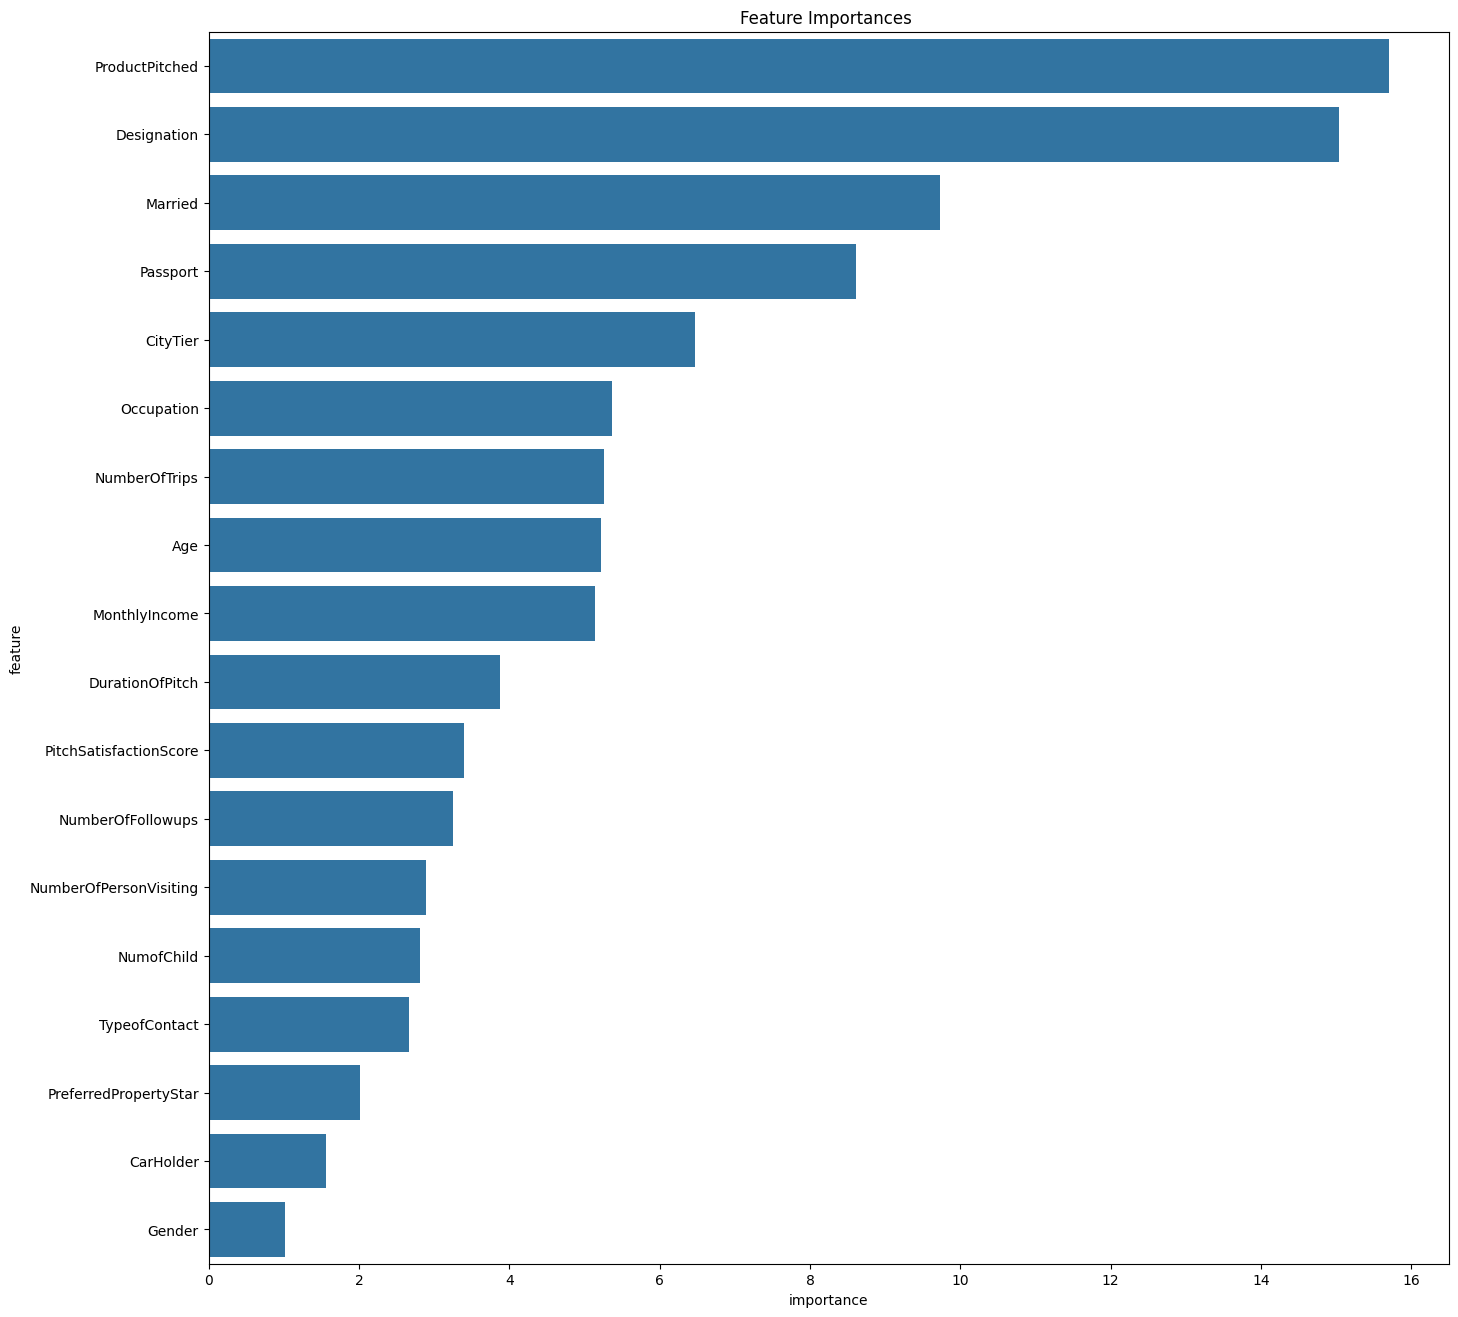

In [154]:
plt.figure(figsize=(16, 16))
sns.barplot(data=o.sort_values(by='importance', ascending=False), x='importance', y='feature')
plt.title('Feature Importances ')

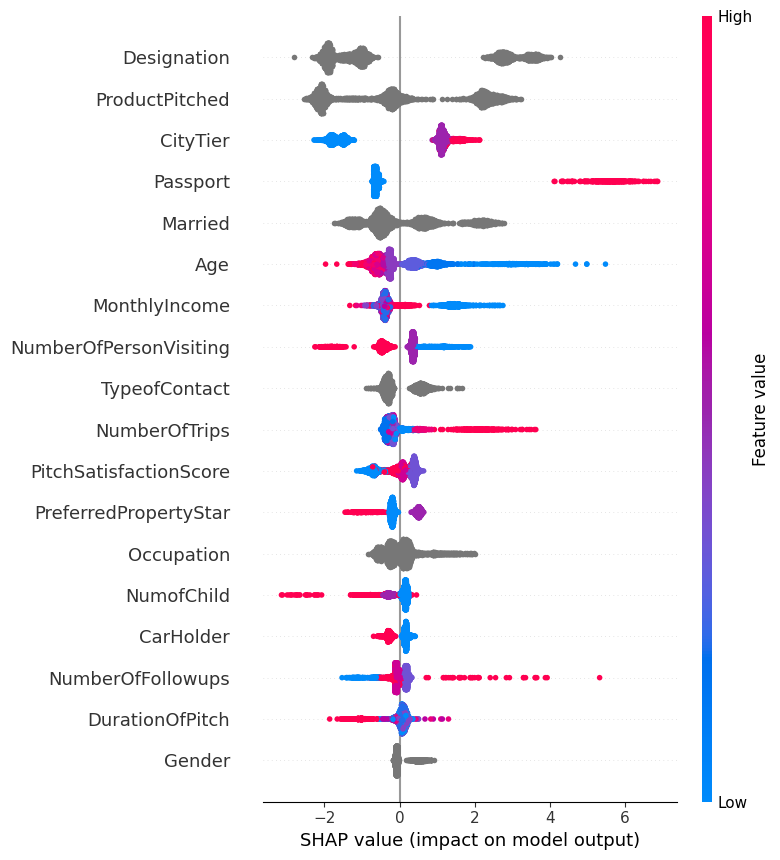

In [155]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()

# 各FOLD、SEEDの和 (相対値なのでこれで良しとする)
shapval = 0
for i in range(5):
  explainer = shap.TreeExplainer(models[i])
  shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))
  shapval = shapval + shap_values

shap.summary_plot(shapval, train.drop("ProdTaken",axis=1))